In [1]:
import numpy as np
import matplotlib.pyplot as plt
import torch
from torch import nn

In [2]:
from scipy import stats
from scipy.stats import norm

In [3]:
plt.rcParams.update({'font.size': 14})

In [4]:
the_seed = 0
np.random.seed(the_seed)
_ = torch.manual_seed(the_seed)

pi = np.array([0.65,0.35])

N = 1000

z = np.random.choice(2,size=N,p=pi)

mu1 = 2.
sigma1 = 0.4

mu2 = 4.
sigma2 = 0.4

s = np.random.randn(N)

x1 = mu1 + sigma1 * s
x2 = mu2 + sigma2 * s

X = np.concatenate((x1[:,None],x2[:,None]),1)

X = X[np.arange(N),z]

In [5]:
class CDFNet(nn.Module):
    """Solve conditional ODE. Single output dim."""
    def __init__(self, hidden_dim, output_dim,
                 nonlinearity=nn.ReLU,
                 device="cpu", n=15, lr=1e-3):
        super().__init__()

        self.output_dim = output_dim

        if device == "gpu":
            self.device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
            print(f"CondODENet: {device} specified, {self.device} used")
        else:
            self.device = torch.device("cpu")
            print(f"CondODENet: {device} specified, {self.device} used")

        self.dudt = nn.Sequential(
            nn.Linear(1, hidden_dim),
            nonlinearity(),

            nn.Linear(hidden_dim, hidden_dim),
            nonlinearity(),

            nn.Linear(hidden_dim, output_dim),
            nn.Softplus()
        )

        self.n = n
        u_n, w_n = np.polynomial.legendre.leggauss(n)
        self.u_n = nn.Parameter(torch.tensor(u_n,device=self.device,dtype=torch.float32)[None,:],requires_grad=False)
        self.w_n = nn.Parameter(torch.tensor(w_n,device=self.device,dtype=torch.float32)[None,:],requires_grad=False)
        self.optimizer = torch.optim.Adam(self.parameters(), lr=lr)
        
    def mapping(self, t):
        t = t[:,None]
        tau = torch.matmul(t/2, 1+self.u_n) # N x n
        tau_ = torch.flatten(tau)[:,None] # Nn x 1. Think of as N n-dim vectors stacked on top of each other
        f_n = self.dudt(tau_).reshape((*tau.shape, self.output_dim)) # N x n x d_out
        pred = t/2 * ((self.w_n[:,:,None] * f_n).sum(dim=1))
        return torch.tanh(pred).squeeze()
    
    def forward(self, t):
        F = self.mapping(t)
        du = self.dudt(t[:,None]).squeeze()
        return -(torch.log(du) + torch.log(1-F**2))
    
    def sum_forward(self, t):
        return self.forward(t).sum()
    
    def optimise(self, t, niters):
        for i in range(niters):
            self.optimizer.zero_grad()
            loss = self.sum_forward(t)
            loss.backward()
            self.optimizer.step()
            if i % 100 == 0:
                print(loss.item())

In [6]:
cnet = CDFNet(32,1,nonlinearity=nn.Tanh)

CondODENet: cpu specified, cpu used


In [7]:
cnet.optimise(torch.tensor(X.astype('float32')),1500)

3050.27880859375
1492.54833984375
1443.949462890625
1402.1112060546875
1373.3936767578125
1352.75732421875
1333.843994140625
1310.1943359375
1275.060546875
1231.6270751953125
1185.799560546875
1146.857421875
1122.76611328125
1112.2686767578125
1108.0509033203125


In [8]:
t_eval = np.linspace(0,5,100)
y = cnet.mapping(torch.tensor(t_eval.astype('float32'))).detach().numpy()
dy = np.exp(-cnet.forward(torch.tensor(t_eval.astype('float32'))).detach().numpy().squeeze())
pdf = pi[0] * norm.pdf(t_eval, loc=mu1, scale=sigma1) + pi[1] * norm.pdf(t_eval, loc=mu2, scale=sigma2)

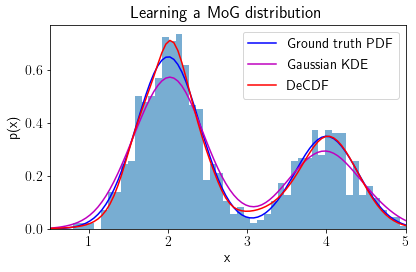

In [9]:
kde = stats.gaussian_kde(X)

fig, ax = plt.subplots()
ax.hist(X, density=True, bins=50, alpha=0.6)
ax.plot(t_eval, pdf, '-b', label='Ground truth PDF')
ax.plot(t_eval, kde(t_eval), '-m', label='Gaussian KDE')
ax.plot(t_eval, dy, '-r', label='DeCDF')
plt.xlabel('x')
plt.ylabel('p(x)')
plt.xlim([0.5,5])
plt.legend()
plt.title("Learning a MoG distribution")
plt.tight_layout()
plt.show()
# plt.savefig('mogfit.pdf', bbox_inches='tight')

In [10]:
the_seed = 0
np.random.seed(the_seed)
_ = torch.manual_seed(the_seed)

N = 1000

# Gaussian
mu = 3
sig = 0.6
x1 = mu + sig*np.random.randn(N)

# Weibull
x2 = np.random.weibull(1.5,size=N)
x3 = np.random.weibull(1.,size=N)

cnet1 = CDFNet(32,1,nonlinearity=nn.Tanh)
cnet2 = CDFNet(32,1,nonlinearity=nn.Tanh)
cnet3 = CDFNet(32,1,nonlinearity=nn.Tanh)

CondODENet: cpu specified, cpu used
CondODENet: cpu specified, cpu used
CondODENet: cpu specified, cpu used


In [11]:
cnet1.optimise(torch.tensor(x1.astype('float32')),1000)

3439.5478515625
1070.201904296875
920.0945434570312
912.5313110351562
907.4148559570312
903.9742431640625
901.77880859375
900.3910522460938
899.4965209960938
898.8922119140625


In [12]:
cnet2.optimise(torch.tensor(x2.astype('float32')),1000)

940.4910278320312
828.632080078125
827.5404663085938
826.221923828125
824.69287109375
822.9791259765625
821.3388671875
820.3455810546875
819.9011840820312
819.6333618164062


In [13]:
cnet3.optimise(torch.tensor(x3.astype('float32')),1000)

1052.6417236328125
1018.922607421875
1018.3316650390625
1017.9202880859375
1017.520751953125
1017.13720703125
1016.828857421875
1016.613525390625
1016.423095703125
1016.2457275390625


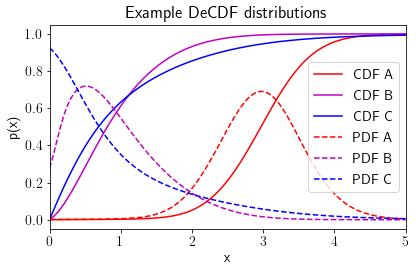

In [14]:
t_eval = np.linspace(0,5,100)
y1 = cnet1.mapping(torch.tensor(t_eval.astype('float32'))).detach().numpy()
dy1 = np.exp(-cnet1.forward(torch.tensor(t_eval.astype('float32'))).detach().numpy().squeeze())
y2 = cnet2.mapping(torch.tensor(t_eval.astype('float32'))).detach().numpy()
dy2 = np.exp(-cnet2.forward(torch.tensor(t_eval.astype('float32'))).detach().numpy().squeeze())
y3 = cnet3.mapping(torch.tensor(t_eval.astype('float32'))).detach().numpy()
dy3 = np.exp(-cnet3.forward(torch.tensor(t_eval.astype('float32'))).detach().numpy().squeeze())

plt.figure()
plt.plot(t_eval,y1,'-r', label='CDF A')
plt.plot(t_eval,y2,'-m', label='CDF B')
plt.plot(t_eval,y3,'-b', label='CDF C')
plt.plot(t_eval,dy1,'--r', label='PDF A')
plt.plot(t_eval,dy2,'--m', label='PDF B')
plt.plot(t_eval,dy3,'--b', label='PDF C')
plt.xlabel('x')
plt.ylabel('p(x)')
plt.xlim([0.,5.])
plt.legend()
plt.title("Example DeCDF distributions")
plt.tight_layout()
plt.show()
# plt.savefig('decdfegs.pdf', bbox_inches='tight')